## Accessing and visualizing ESA CCI version 4 data from the MAAP STAC catalog

Authors: Emile Tenezakis (DevSeed), Rajat Shinde (UAH)

Date: September 12, 2023

Description: In this tutorial, we explore accessing and visualizing ESA CCI Version 4 data from the MAAP STAC catalog. We make use of the [stackstac package](https://github.com/gjoseph92/stackstac) that allows us to turn a stack collection imported from the catalog with the [`pystac_client`](https://pystac-client.readthedocs.io/en/stable/) to an xarray dataset, and we plot the time series of the mean aboveground biomass for a selected tile of the dataset across the available temporal range.

### Run This Notebook
To access and run this tutorial within MAAP's Algorithm Development Environment (ADE), please refer to the ["Getting started with the MAAP"](https://docs.maap-project.org/en/latest/getting_started/getting_started.html) section of our documentation.

Disclaimer: it is highly recommended to run a tutorial within MAAP's ADE, which already includes packages specific to MAAP, such as maap-py. Running the tutorial outside of the MAAP ADE may lead to errors.

### Requirements

Create a conda environment with a configuration file to which you will paste the following

Make the `esa-cci` environment available as a notebook kernel and choose it to run this notebook. 

In [6]:
from stackstac import stack, mosaic
import pystac_client
import matplotlib.pyplot as plt 
import numpy as np
import pystac
import xarray

We first create a client to access the STAC test catalog.

In [7]:
URL = "https://stac.maap-project.org"
catalog = pystac_client.Client.open(URL)

We create a bounding box of interest to find the tile that covers a small region around manaus, brazil (amazon rainforest).

In [8]:
# Filtering for the items in the collection
bbox = [-55,-6,-54.8,-5.8]

We proceed to an item search in the catalog using the `pystac-client`, filtering items covering our area of interest.

In [9]:
stac_collection = catalog.search(
    collections=["ESACCI_Biomass_L4_AGB_V4_100m"],
    bbox=bbox
)

Let's take a quick look at the results of the search. We may be for example interested in knowing where the data is stored.

In [10]:
stac_collection.get_all_items()[0].assets['estimates'].href

's3://nasa-maap-data-store/file-staging/nasa-map/ESACCI_Biomass_L4_AGB_V4_100m_2020/N00W060_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2020-fv4.0.tif'

We turn the resulting set of items (we expect one item here in the result, given the size of our bounding box) into an xarray DataArray using `stackstac`.

In [11]:
#Change variable name
arr = stack(stac_collection.get_all_items())

/opt/conda/lib/python3.10/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


We can see that our array has the following dimensions : time (we have four data points, one for each year), latitude, longitude and band (we have two bands : the AGB estimates and the AGB standard deviation)

In [12]:
arr

<xarray.DataArray 'stackstac-0d88a6aa99e2eb93c2b68b6e8780c93c' (time: 4,
                                                                band: 2,
                                                                y: 11250,
                                                                x: 11251)>
dask.array<fetch_raster_window, shape=(4, 2, 11250, 11251), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * time            (time) datetime64[ns] 2017-01-01 2018-01-01 ... 2020-01-01
    id              (time) <U52 'N00W060_ESACCI-BIOMASS-L4-AGB-MERGED-100m-20...
  * band            (band) <U18 'estimates' 'standard_deviation'
  * x               (x) float64 -60.0 -60.0 -60.0 -60.0 ... -50.0 -50.0 -50.0
  * y               (y) float64 0.0 -0.0008889 -0.001778 ... -9.998 -9.999
    proj:transform  object {0.0, 1.0, -0.00088888888888, -60.0, 0.00088888888...
    ...              ...
    proj:shape      object {11250}
    proj:bbox       object {0.0, -60.0, -50.0000000001, -9.9999999999}
    proj:epsg       int64 4326
    title           (band) <U49 'Cloud Optimized GeoTIFF of AGB estimates' 'C...
    description     (band) <U49 'Cloud Optimized GeoTIFF of AGB estimates' 'C...
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-60.00088888828888, -9.9999999...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-60.00|\n| 0.00,-0.00, 0.00|\n| 0.00, 0.00, 1.00|
    resolution:  0.00088888888888

Now, we will perform a spatial filtering operation and select a subset of the created stack as it is compute intensive to run experiments on the entire stack due to its size. 

In [16]:
min_x = -55
min_y = -3.0
max_x = -50.0 
max_y = -5.0

arr_sub = arr.sel(x=slice(min_x, max_x), y=slice(min_y, max_y))
arr_sub

<xarray.DataArray 'stackstac-0d88a6aa99e2eb93c2b68b6e8780c93c' (time: 4,
                                                                band: 2,
                                                                y: 2250, x: 5625)>
dask.array<getitem, shape=(4, 2, 2250, 5625), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/13)
  * time            (time) datetime64[ns] 2017-01-01 2018-01-01 ... 2020-01-01
    id              (time) <U52 'N00W060_ESACCI-BIOMASS-L4-AGB-MERGED-100m-20...
  * band            (band) <U18 'estimates' 'standard_deviation'
  * x               (x) float64 -55.0 -55.0 -55.0 -55.0 ... -50.0 -50.0 -50.0
  * y               (y) float64 -3.001 -3.002 -3.003 ... -4.998 -4.999 -5.0
    proj:transform  object {0.0, 1.0, -0.00088888888888, -60.0, 0.00088888888...
    ...              ...
    proj:shape      object {11250}
    proj:bbox       object {0.0, -60.0, -50.0000000001, -9.9999999999}
    proj:epsg       int64 4326
    title           (band) <U49 'Cloud Optimized GeoTIFF of AGB estimates' 'C...
    description     (band) <U49 'Cloud Optimized GeoTIFF of AGB estimates' 'C...
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-60.00088888828888, -9.9999999...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-60.00|\n| 0.00,-0.00, 0.00|\n| 0.00, 0.00, 1.00|
    resolution:  0.00088888888888

### Masking values based on a condition

Below, we will explore how to mask few values based on a condition and plot the time series for the filtered array.

In [19]:
arr_est = arr_sub.sel(band='estimates')

Let's try to print the values of the `arr_est`.

In [22]:
arr_est.values

array([[[274., 215., 295., ..., 221., 181., 143.],
        [248., 285., 284., ..., 165., 190., 165.],
        [244., 224., 274., ..., 188., 182., 162.],
        ...,
        [351., 382., 376., ...,  22.,  41.,  41.],
        [340., 343., 358., ...,   0.,   0.,  50.],
        [289., 320., 334., ...,   0.,   0.,  51.]],

       [[219., 184., 278., ..., 219., 237., 214.],
        [213., 227., 275., ..., 188., 236., 239.],
        [241., 233., 313., ..., 205., 210., 197.],
        ...,
        [379., 379., 379., ...,  41.,  68.,  34.],
        [333., 368., 371., ...,   0.,   0.,  39.],
        [329., 365., 379., ...,   0.,   0.,  38.]],

       [[325., 182., 273., ..., 257., 262., 261.],
        [234., 302., 204., ..., 228., 252., 202.],
        [316., 301., 292., ..., 166., 256., 144.],
        ...,
        [385., 302., 388., ...,   7.,   5.,   4.],
        [323., 327., 300., ...,   0.,   0.,   8.],
        [406., 406., 309., ...,   0.,   0.,  10.]],

       [[287., 128., 292., ..., 192.,

Now, we are going to filter the values which are less than 10. In the resulting xarray, all the values less than 10 are going to be `nan`. We can also replace `nan` by any other value.

In [25]:
arr_masked_lt = arr_est.where(arr_est >= 10)
arr_masked_lt.values

array([[[274., 215., 295., ..., 221., 181., 143.],
        [248., 285., 284., ..., 165., 190., 165.],
        [244., 224., 274., ..., 188., 182., 162.],
        ...,
        [351., 382., 376., ...,  22.,  41.,  41.],
        [340., 343., 358., ...,  nan,  nan,  50.],
        [289., 320., 334., ...,  nan,  nan,  51.]],

       [[219., 184., 278., ..., 219., 237., 214.],
        [213., 227., 275., ..., 188., 236., 239.],
        [241., 233., 313., ..., 205., 210., 197.],
        ...,
        [379., 379., 379., ...,  41.,  68.,  34.],
        [333., 368., 371., ...,  nan,  nan,  39.],
        [329., 365., 379., ...,  nan,  nan,  38.]],

       [[325., 182., 273., ..., 257., 262., 261.],
        [234., 302., 204., ..., 228., 252., 202.],
        [316., 301., 292., ..., 166., 256., 144.],
        ...,
        [385., 302., 388., ...,  nan,  nan,  nan],
        [323., 327., 300., ...,  nan,  nan,  nan],
        [406., 406., 309., ...,  nan,  nan,  10.]],

       [[287., 128., 292., ..., 192.,

Now, let's try to perform filtering based on the opposite condition so as to mask all the values greater than 10.

In [26]:
arr_masked_gt = arr_est.where(arr_est <= 10)
arr_masked_gt.values

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ...,  0.,  0., nan],
        [nan, nan, nan, ...,  0.,  0., nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ...,  0.,  0., nan],
        [nan, nan, nan, ...,  0.,  0., nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  7.,  5.,  4.],
        [nan, nan, nan, ...,  0.,  0.,  8.],
        [nan, nan, nan, ...,  0.,  0., 10.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ..

### Plotting mean time-series

Below we will look into plotting the mean time-series for the `estimate` band. We will be using the `compute()` module of the `dask` which performs an in-memory computation in a parallel approach.

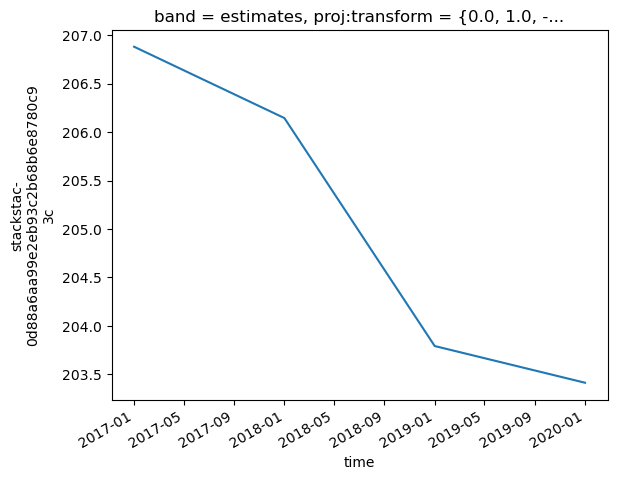

In [33]:
mean_time_series = arr_est.mean(['x','y']).compute()
mean_time_series.plot()

Let's try to visualize the time series of the filtered array using the 1st condition mentioned above for masking all the values above 10. We will create a function based on above code with `floor` as a parameter to be used for filtering. 

In [30]:
def plot_mean_time_series(da=arr_est, band='estimates', floor=None):
    """ selects a band from `da`, optionally keeps only values above `floor`, calculates the spatial average and plots the resulting time series"""
    # da = da.sel(band=band)
    da_filtered = da if floor is None else da.where(da.values >= floor)
    av = da.mean(['x','y']).compute()
    av.plot()

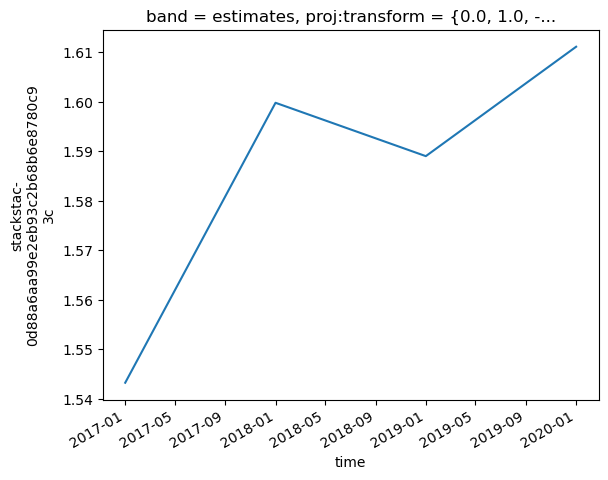

In [31]:
plot_mean_time_series(da=arr_masked_gt, floor=10)